In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

modify the working directory

In [2]:
current_dir = os.getcwd()
print("Current Working Directory:", current_dir)
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
os.chdir(parent_dir)
print("New Working Directory:", os.getcwd())


Current Working Directory: /local/scratch/yxie289/mlproject/docs
New Working Directory: /local/scratch/yxie289/mlproject


# Checking the dataset

open the annotation json file 'MMHS150K_GT.json', consisting of tweet text and label

In [3]:
IMAGE_FOLDER = './dataset/img_resized/'
TEXT_FOLDER = './dataset/img_txt/'
annotations = './dataset/MMHS150K_GT.json'
import json
 
# Opening JSON file
with open(annotations) as json_file:
    data = json.load(json_file)

data_df = pd.DataFrame(data).T.reset_index()
data_df.rename(columns = {'index':'id'}, inplace = True)
data_df.head()

,id,img_url,labels,tweet_url,tweet_text,labels_str
0,1114679353714016256,http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...,"[4, 1, 3]",https://twitter.com/user/status/11146793537140...,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[Religion, Racist, Homophobe]"
1,1063020048816660480,http://pbs.twimg.com/ext_tw_video_thumb/106301...,"[5, 5, 5]",https://twitter.com/user/status/10630200488166...,My horses are retarded https://t.co/HYhqc6d5WN,"[OtherHate, OtherHate, OtherHate]"
2,1108927368075374593,http://pbs.twimg.com/media/D2OzhzHUwAADQjd.jpg,"[0, 0, 0]",https://twitter.com/user/status/11089273680753...,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[NotHate, NotHate, NotHate]"
3,1114558534635618305,http://pbs.twimg.com/ext_tw_video_thumb/111401...,"[1, 0, 0]",https://twitter.com/user/status/11145585346356...,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[Racist, NotHate, NotHate]"
4,1035252480215592966,http://pbs.twimg.com/media/Dl30pGIU8AAVGxO.jpg,"[1, 0, 1]",https://twitter.com/user/status/10352524802155...,“EVERYbody calling you Nigger now!” https://t....,"[Racist, NotHate, Racist]"


read the split dataset file

In [4]:
train_df = pd.read_csv('./dataset/splits/train_ids.txt', header=None)
train_df.columns = ['id']
valid_df = pd.read_csv('./dataset/splits/val_ids.txt', header=None)
valid_df.columns = ['id']
test_df = pd.read_csv('./dataset/splits/test_ids.txt', header=None)
test_df.columns = ['id']

In [5]:
train_df['image_path'] = IMAGE_FOLDER + train_df['id'].astype(str) + '.jpg'
valid_df['image_path'] = IMAGE_FOLDER + valid_df['id'].astype(str) + '.jpg'
test_df['image_path'] = IMAGE_FOLDER + test_df['id'].astype(str) + '.jpg'

In [6]:
train_df['img_text_path'] = TEXT_FOLDER + train_df['id'].astype(str) + '.json'
valid_df['img_text_path'] = TEXT_FOLDER + valid_df['id'].astype(str) + '.json'
test_df['img_text_path'] = TEXT_FOLDER + test_df['id'].astype(str) + '.json'

In [7]:
train_df['id'] = train_df['id'].astype(str)
test_df['id'] = test_df['id'].astype(str)
valid_df['id'] = valid_df['id'].astype(str)

In [8]:
data_df['id'] = data_df['id'].astype(str)
train_df = train_df.merge(data_df, on='id', how='left')
valid_df = valid_df.merge(data_df, on='id', how='left')
test_df = test_df.merge(data_df, on='id', how='left')

create labels for samples

In [9]:
train_df['label'] = train_df['labels'].apply(sum).apply(lambda x: 1 if x > 0 else 0)
valid_df['label'] = valid_df['labels'].apply(sum).apply(lambda x: 1 if x > 0 else 0)
test_df['label'] = test_df['labels'].apply(sum).apply(lambda x: 1 if x > 0 else 0)

In [10]:
print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())
print(test_df['label'].value_counts())

1    80764
0    54059
Name: label, dtype: int64
1    3717
0    1283
Name: label, dtype: int64
1    7411
0    2589
Name: label, dtype: int64


check whether a sample has three modalities: image, img_text, tweet_text

In [11]:
train_df['tweet_text'].apply(len).describe()

count    134823.000000
mean         84.733918
std          28.185489
min          28.000000
25%          62.000000
50%          82.000000
75%         107.000000
max         164.000000
Name: tweet_text, dtype: float64

Every sample has its tweet text, the minimum length is 28 

In [12]:
train_df.iloc[0]

id                                             1057393737372966912
image_path           ./dataset/img_resized/1057393737372966912.jpg
img_text_path           ./dataset/img_txt/1057393737372966912.json
img_url             http://pbs.twimg.com/media/Dqyd_GzW4AE2ElU.jpg
labels                                                   [5, 1, 1]
tweet_url        https://twitter.com/user/status/10573937373729...
tweet_text       Thats  what u call a redneck lol https://t.co/...
labels_str                             [OtherHate, Racist, Racist]
label                                                            1
Name: 0, dtype: object

In [13]:
train_df['img_text_filename'] = train_df['img_text_path'].str.split('/').apply(lambda a:a[-1])
valid_df['img_text_filename'] = valid_df['img_text_path'].str.split('/').apply(lambda a:a[-1])
test_df['img_text_filename'] = test_df['img_text_path'].str.split('/').apply(lambda a:a[-1])
train_df['img_text_available'] = train_df['img_text_filename'].isin(os.listdir(TEXT_FOLDER))
valid_df['img_text_available'] = valid_df['img_text_filename'].isin(os.listdir(TEXT_FOLDER))
test_df['img_text_available'] = test_df['img_text_filename'].isin(os.listdir(TEXT_FOLDER))

In [14]:
print(train_df['img_text_available'].value_counts())
print(valid_df['img_text_available'].value_counts())
print(test_df['img_text_available'].value_counts())

False    81667
True     53156
Name: img_text_available, dtype: int64
False    2967
True     2033
Name: img_text_available, dtype: int64
False    5937
True     4063
Name: img_text_available, dtype: int64


Some samples don't have image-text data type, but that doesn't matter because they still have tweet-text data 

In [15]:
train_df['image_filename'] = train_df['image_path'].str.split('/').apply(lambda a:a[-1])
valid_df['image_filename'] = valid_df['image_path'].str.split('/').apply(lambda a:a[-1])
test_df['image_filename'] = test_df['image_path'].str.split('/').apply(lambda a:a[-1])
train_df['image_available'] = train_df['image_filename'].isin(os.listdir(IMAGE_FOLDER))
valid_df['image_available'] = valid_df['image_filename'].isin(os.listdir(IMAGE_FOLDER))
test_df['image_available'] = test_df['image_filename'].isin(os.listdir(IMAGE_FOLDER))

In [16]:
print(train_df['image_available'].value_counts())
print(valid_df['image_available'].value_counts())
print(test_df['image_available'].value_counts())

True    134823
Name: image_available, dtype: int64
True    5000
Name: image_available, dtype: int64
True    10000
Name: image_available, dtype: int64


Every sample has its image data

Write function to show the image-text data of certain samples

In [17]:
def read_img_text(path):
    # read the image-text data for certain samples using the path of a json file
    if path != '':
        with open(path) as json_file:
            data = json.load(json_file)
            return data['img_text']
    return ''
train_df[train_df['img_text_available']==True]['img_text_path'].iloc[:10].apply(read_img_text)

0                                            a bunch c 
1                                 nericansForTruth.org 
2                                            CHEVROLET 
7     trixie as a cheerleader trixie a a- cheerleade...
9                                      CHELSEA HANDLER 
13               Cock NASTY B , DADDY SWA Fuck T OL UM 
15                                             oumpkin 
16    Meek Mill Flexes with OVO Chain Following Drak...
18    Peaches 7m ago People need 2 learn 2 mind ther...
24                                        MAKE SHIT UP 
Name: img_text_path, dtype: object

Write function to show the image of certain samples

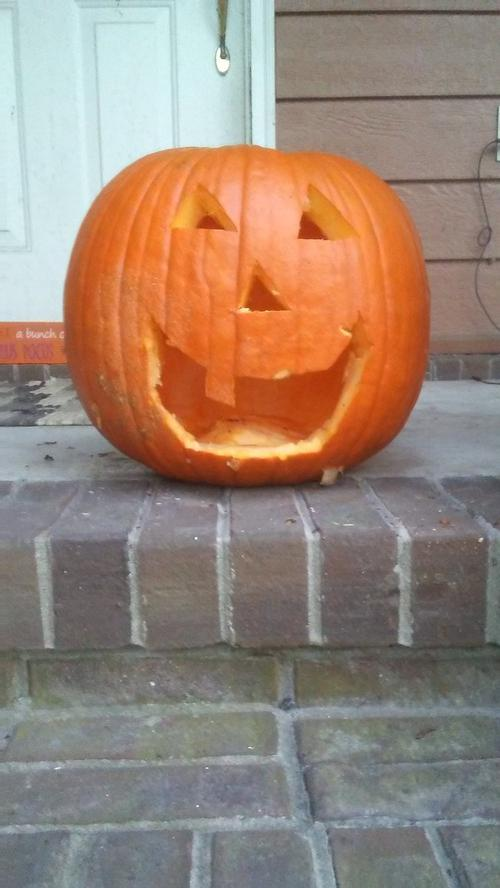

In [18]:
def read_image(path):
    # read the image data for certain samples using the path of a jpg file, return the Image datatype
    if path != '':
        im = Image.open(path)
        # plt.imshow(im)
        return im
    return ''
display(train_df[train_df['image_available']==True]['image_path'].iloc[:10].apply(read_image).iloc[0])

see the keywords directory, remove some specical characters in the keyword

In [29]:
with open('./dataset/hatespeech_keywords.txt', 'r') as file:
    lines = file.readlines()
keywords = [line.strip().replace('#', '') for line in lines]

In [30]:
keywords

['asian drive',
 'feminazi',
 'sjw',
 'WomenAgainstFeminism',
 'blameonenotall',
 'islam terrorism',
 'notallmen',
 'victimcard',
 'victim card',
 'arab terror',
 'gamergate',
 'jsil',
 'racecard',
 'race card',
 'refugeesnotwelcome',
 'DeportallMuslims',
 'banislam',
 'banmuslims',
 'destroyislam',
 'norefugees',
 'nomuslims',
 'border jumper',
 'border nigger',
 'boojie',
 'surrender monkey',
 'chinaman',
 'hillbilly',
 'whigger',
 'white nigger',
 'wigger',
 'wigerette',
 'bitter clinger',
 'conspiracy theorist',
 'redneck',
 'rube',
 'trailer park trash',
 'trailer trash',
 'white trash',
 'yobbo',
 'retard',
 'retarded',
 'nigger',
 'white trash',
 'trailer trash',
 'coonass',
 'trailer park trash',
 'raghead',
 'house nigger',
 'white nigger',
 'camel fucker',
 'moon cricket',
 'wetback',
 'spic',
 'bint',
 'dyke',
 'twat',
 'bamboo coon',
 'camel fucker',
 'chinaman',
 'limey',
 'plastic paddy',
 'sideways pussy',
 'surrender monkey',
 'whigger',
 'white nigger',
 'wigger',
 'zi

In [66]:
def text_contains_keyword(text, keywords):
    contain = []
    for word in keywords:
        if word in text:
            contain.append(1)
        else:
            contain.append(0)
    return contain
train_df['tweet_text'].apply(lambda x: x.lower()).apply(text_contains_keyword, args=(keywords, )).apply(sum).value_counts()

1    115395
2     13551
0      5605
3       256
4        15
6         1
Name: tweet_text, dtype: int64

Most tweet texts contain 1 or 2 keywords

save all the basic information of the dataset 

In [69]:
train_df.to_csv('./dataset/basic_info/train.csv', index=False)
valid_df.to_csv('./dataset/basic_info/valid.csv', index=False)
test_df.to_csv('./dataset/basic_info/test.csv', index=False)

In [70]:
train_df['split'] = 'train'
valid_df['split'] = 'valid'
test_df['split'] = 'test'
all_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=True)
all_df.to_csv('./dataset/basic_info/all.csv', index=False)

In [73]:
all_df

,id,image_path,img_text_path,img_url,labels,tweet_url,tweet_text,labels_str,label,img_text_filename,img_text_available,image_filename,image_available,split
0,1057393737372966912,./dataset/img_resized/1057393737372966912.jpg,./dataset/img_txt/1057393737372966912.json,http://pbs.twimg.com/media/Dqyd_GzW4AE2ElU.jpg,"[5, 1, 1]",https://twitter.com/user/status/10573937373729...,Thats what u call a redneck lol https://t.co/...,"[OtherHate, Racist, Racist]",1,1057393737372966912.json,True,1057393737372966912.jpg,True,train
1,1057149180148240384,./dataset/img_resized/1057149180148240384.jpg,./dataset/img_txt/1057149180148240384.json,http://pbs.twimg.com/media/Dqu_kg0UwAA70sS.jpg,"[0, 3, 1]",https://twitter.com/user/status/10571491801482...,@mortals @Ghostzro Nigga forgot mortal 😭 morta...,"[NotHate, Homophobe, Racist]",1,1057149180148240384.json,True,1057149180148240384.jpg,True,train
2,1113184475658293251,./dataset/img_resized/1113184475658293251.jpg,./dataset/img_txt/1113184475658293251.json,http://pbs.twimg.com/media/D3LTXs3W4AAbHrk.jpg,"[1, 0, 1]",https://twitter.com/user/status/11131844756582...,Nigga if ain't interested in playing for the t...,"[Racist, NotHate, Racist]",1,1113184475658293251.json,True,1113184475658293251.jpg,True,train
3,1108665597510991873,./dataset/img_resized/1108665597510991873.jpg,./dataset/img_txt/1108665597510991873.json,http://pbs.twimg.com/media/D2LFd5WXgAAeK0A.jpg,"[0, 2, 2]",https://twitter.com/user/status/11086655975109...,Love a BBC So faggot slut https://t.co/Woji3I...,"[NotHate, Sexist, Sexist]",1,1108665597510991873.json,False,1108665597510991873.jpg,True,train
4,1108732814202228737,./dataset/img_resized/1108732814202228737.jpg,./dataset/img_txt/1108732814202228737.json,http://pbs.twimg.com/media/D2MCnJtXgAEKsVc.jpg,"[2, 0, 1]",https://twitter.com/user/status/11087328142022...,@Chief30k leaked Pics of Dog Nigga live action...,"[Sexist, NotHate, Racist]",1,1108732814202228737.json,False,1108732814202228737.jpg,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149818,1109972327897460736,./dataset/img_resized/1109972327897460736.jpg,./dataset/img_txt/1109972327897460736.json,http://pbs.twimg.com/media/D2dp8PSX4AAKinS.jpg,"[0, 0, 0]",https://twitter.com/user/status/11099723278974...,"""Would you just say I'll join. And that would ...","[NotHate, NotHate, NotHate]",0,1109972327897460736.json,False,1109972327897460736.jpg,True,test
149819,1106756324803731456,./dataset/img_resized/1106756324803731456.jpg,./dataset/img_txt/1106756324803731456.json,http://pbs.twimg.com/media/D1v9Ap6X4AAraRU.jpg,"[1, 0, 0]",https://twitter.com/user/status/11067563248037...,@giIgameth nah my nigga that was out pocket 😭 ...,"[Racist, NotHate, NotHate]",1,1106756324803731456.json,False,1106756324803731456.jpg,True,test
149820,1114945824851730434,./dataset/img_resized/1114945824851730434.jpg,./dataset/img_txt/1114945824851730434.json,http://pbs.twimg.com/media/D3kVUH1WsAAzhbK.jpg,"[0, 0, 0]",https://twitter.com/user/status/11149458248517...,@laura_roshni is a tory cunt confirmed!!! http...,"[NotHate, NotHate, NotHate]",0,1114945824851730434.json,False,1114945824851730434.jpg,True,test
149821,1105122471743635456,./dataset/img_resized/1105122471743635456.jpg,./dataset/img_txt/1105122471743635456.json,http://pbs.twimg.com/tweet_video_thumb/D1YvBV_...,"[0, 0, 0]",https://twitter.com/user/status/11051224717436...,"Whenever an incel calls me a SJW or a cunt, or...","[NotHate, NotHate, NotHate]",0,1105122471743635456.json,False,1105122471743635456.jpg,True,test
